After a brilliant long meeting at the end of week 4 we are coming towards a big step in the project. Calculating the column density. Before attempting to calculate the column densitites myself for numerous lines and potentially map the Mn II lines I found in week 3, I should ammend my set_w function from week 4 - objectives 1.     
1. Clean my set_w function        
2. Get the an equivalent column_density notebook working      
3. Add Mn to the line list - as the atomic data file doesnt include it. / make my own line list (combing Atomic Data with selected data from NIST)
4. Try calculate the column density of the Mn II lines found in week 3.   
5. Make a function which plots the expected lines given the wavelength region and element. 
6. Calculate column density of any other lines I like the look of 

In [1]:
import numpy as np
import json, sys, os

import matplotlib.pyplot as plt
from matplotlib import rc, cm

## Preparing astropy units and constants to be used later
from astropy import units as u
from astropy import constants as const

# Get the path of the current directory
path = os.getcwd()
home = os.path.dirname(path)

# Print the repository home directory
print("Repository home directory:",home)

# Add the src folder to the system path
sys.path.append(home+'/src')

# Import the python functions stored in the src folder
from calculations import Calc, Model, Stats

# We shorten the functions name to make it easier to call the required a functions
## 3 functions from P.Strom written code
c   = Calc()
m   = Model()
s   = Stats()

## My set_w function 
### Revisitied in week 5 to set it as a new variable rather than overwriting w (could have caused problems with repetition)

def set_w(lowerw,upperw):
    # Must make w, w_LHS and w_RHS global here so that they can be recalled later outside of the function
    #otherwise they stay as just local inside set_w
    global w
    global w_trim
    global w_LHS
    global w_RHS
    
    #Finding the wavelength range to then find the number of data points per angstrom
    w = D[0][0][0][0:20248]
 
    # Wavelength range
    w_range = (w[20247]-w[0])

    # Data points per wavelength
    p_per_w = 20248/w_range
    
    LHS_gap_w = (lowerw-w[0]) #LHS difference in angstroms 
    LHS_gap_d = LHS_gap_w*p_per_w # LHS difference in points
    LHS_gap_d = round(LHS_gap_d)
    
    RHS_gap_w = (w[20247]-upperw) #RHS difference in angstroms 
    RHS_gap_d = RHS_gap_w*p_per_w # RHS difference in points
    RHS_gap_d = round(RHS_gap_d)
    
    w_LHS = 0 + LHS_gap_d
    w_RHS = 20248 - RHS_gap_d

    w_trim = D[0][0][0][w_LHS:w_RHS] #Redefining w with its new boundaries
    
    print("w_trim = ")
    return(w_trim)



# Importing parameters from a json file.
# You can use this file to edit parameters later.

## Editing the paramenters in a file proves easier than writing it into the code 
with open(home+'/params.json') as param_file:    
   param = json.load(param_file)

# We read in the data directories we are using. To see what directories this is open params.json.
datadirs = param["datadirs"]

# Choose what part of the spectrum you wan to look at
# B is the blue end, whilst A is the red end)
part     = param["BetaPictoris"]["part"]


## Just added this into the first cell as there wasnt any reason to have them split every other week
# Load the data into the multidimentional array D
if param["filenames"]["split_files"] == "yes":
    D = c.LoadData(home+'/data/D_'+part+'_split.npz')
else:
    D = c.LoadData(home+'/data/D_'+part+'.npz')

Repository home directory: C:\Users\Oliver\Documents\urss


In [2]:
# Testing the function (added "w_trim = " to remind to use its new name)
set_w(1320,1440)

w_trim = 


array([1319.69879417, 1319.70876084, 1319.71872751, ..., 1438.79052125,
       1438.80048792, 1438.81045459])

In [3]:
# Testing again if the new varibale can be recalled outside of the function itself (global variable)
print(w_trim)


[1319.69879417 1319.70876084 1319.71872751 ... 1438.79052125 1438.80048792
 1438.81045459]


Objective 1 complete: this should prevent problems when repeating the set_w function in a notebook. It also just seems neater to give it its own name to be recalled.

Now onto a more daunting part of the week but I am feeling hopeful and inspired. The meeting was very informative and I think I know exactly how to do this. I am actually going to try to do objective 3 before 2 and use my own line list "ExpectedLineList" before later then making a combined "MasterLineList". To make the expected line list I am going to use NIST once again, search for all lines from the list of expected elements (written in week 4.2- Na, C, Mg, Al, Fe, Ni , O , Cu , Mn , Cl, S, Si ) for the range of the whole spectrum, save it in excel as a csv, then follow column_density notebook to read it with pandas etc. 

In [4]:
## Ion    Observed Wavelength      Strength 
import pandas as pd
df = pd.read_csv(home+'/GilesExpectedLineList.csv',header=None)
print(df)

           0             1          2
0      Fe V   1200.183       5.0e+07 
1     Fe II   1200.477        5.e+06 
2      Al V   1200.56       5.41e+07 
3     Fe II   1200.889       2.3e+07 
4      Ni V   1200.939      8.41e+07 
...      ...           ...        ...
1752   Fe V   1474.275       5.5e+07 
1753    S I   1474.3800     4.88e+07 
1754  Fe II   1474.412       1.8e+07 
1755    S I   1474.5715     5.39e+06 
1756  Fe II   1474.716       1.2e+07 

[1757 rows x 3 columns]


In [5]:
## From Week 2 and 3
## Code for Normalising the Points in new reigon

# Creating empty lists for our Flux, Error in Flux, corrected flux values 
d0 = [] # Flux
e0 = [] # Error
d0_n = [] # Corrected flux values (Normalised)

# Extracting the Flux and Flux Error data for each observation and putting them into d0 and e0
for i in range(len(D)): # For each visit (repeat for all 13 data collections)
    for j in range(len(D[i])): # Within each visit (cycle over number of orbits)
        if j == 0: # If orbit == 0 (for the first orbit only - as we are interested in unshifted data)
            d0.append(D[i][j][1][w_LHS:w_RHS]) # Add to d0 the y values (Flux)
            e0.append(D[i][j][2][w_LHS:w_RHS]) # Add to e0 the y error values (Error in Flux)
                ## This is why I had to make w_LHS and w_RHS global earlier as well as w
            
# Converting lists into numpy arrays (allowing for easier manipulation later on with averaging functions)
d0 = np.array(d0)
e0 = np.array(e0)


# Normalisation - correcting for different exposure times (exposure time effects Flux, we move all into same frame)

for i in range(len(d0)): # For loop - repeating for each data set 
    factor = np.median(d0[i])/np.median(d0[0]) # Calculating the normalisation factor (how much each spectrum is off from 1st)
    d0_n.append(d0[i]/factor) # (Spectrum flux values/spectrum normalisation factor), making d0_n corrected flux values 


# Converting list into array - only after using .append 
d0_n = np.array(d0_n)

## Simple average
#d0_ave = np.average(d0,axis=0)

## Weighted average
#d0_w_ave = np.average(d0 , axis = 0 , weights = 1/e0**2)

## Normalised weighted average 
d0_n_w_ave = np.average(d0_n , axis = 0 , weights = 1/e0**2)


##Doppler Shift 

beta_pic_speed = 20.5*(u.km/u.s)
w_shifted = w_trim-(beta_pic_speed / const.c)*w_trim


In [27]:
#Here I figured out I have to set the data types to float otherwise in the for index... later it is trying to compare with
# < and > intergers and strings (so we change the strings to floats to match the decimal places)
df[1] = df[1].astype('float')
df[2] = df[2].astype('float')
#This was just a test to see if the data types changed properly.
for index, row in df.iterrows():
    print(row[0], type(row[1]), type(row[2]))

 ClI <class 'float'> <class 'float'>
 ArVI* <class 'float'> <class 'float'>
 ClI <class 'float'> <class 'float'>
 HDLP4V10 <class 'float'> <class 'float'>
 HDLP8V12 <class 'float'> <class 'float'>
 H2LR8V11 <class 'float'> <class 'float'>
 HDLR7V11 <class 'float'> <class 'float'>
 H2WP6V01 <class 'float'> <class 'float'>
 ClI* <class 'float'> <class 'float'>
 CrIIIer <class 'float'> <class 'float'>
 NiII <class 'float'> <class 'float'>
 H2LP4V09 <class 'float'> <class 'float'>
 ClI* <class 'float'> <class 'float'>
 HDLR5V10 <class 'float'> <class 'float'>
 H2WR8V01 <class 'float'> <class 'float'>
 H2LR0V08 <class 'float'> <class 'float'>
 HDLR0V09 <class 'float'> <class 'float'>
 H2LP6V10 <class 'float'> <class 'float'>
 FeII <class 'float'> <class 'float'>
 V III <class 'float'> <class 'float'>
 V III* <class 'float'> <class 'float'>
 H2WQ7V01 <class 'float'> <class 'float'>
 ClI <class 'float'> <class 'float'>
 CO0_33R9 <class 'float'> <class 'float'>
 HDLR1V09 <class 'float'> <class

 SiII <class 'float'> <class 'float'>
 CoII <class 'float'> <class 'float'>
 H2LR4V07 <class 'float'> <class 'float'>
 H2WP5V00 <class 'float'> <class 'float'>
 H2LR8V09 <class 'float'> <class 'float'>
 S III** <class 'float'> <class 'float'>
 ArVI* <class 'float'> <class 'float'>
 H2WQ6V00 <class 'float'> <class 'float'>
 S II <class 'float'> <class 'float'>
 V III* <class 'float'> <class 'float'>
 S III** <class 'float'> <class 'float'>
 HDLR0V07 <class 'float'> <class 'float'>
 S II <class 'float'> <class 'float'>
 C I* <class 'float'> <class 'float'>
 HDLR1V07 <class 'float'> <class 'float'>
 ClI <class 'float'> <class 'float'>
 HDWR9V00 <class 'float'> <class 'float'>
 C I** <class 'float'> <class 'float'>
 ClI <class 'float'> <class 'float'>
 HDLP7V09 <class 'float'> <class 'float'>
 FeII977 <class 'float'> <class 'float'>
 H2LP6V08 <class 'float'> <class 'float'>
 HDLP1V07 <class 'float'> <class 'float'>
 HDWP9V00 <class 'float'> <class 'float'>
 H2LP9V10 <class 'float'> <class 

 ClI* <class 'float'> <class 'float'>
 CrIII** <class 'float'> <class 'float'>
 HDLR3V06 <class 'float'> <class 'float'>
 CrIII*** <class 'float'> <class 'float'>
 CoII* <class 'float'> <class 'float'>
 CrIIIer <class 'float'> <class 'float'>
 CrIII** <class 'float'> <class 'float'>
 H2LR7V07 <class 'float'> <class 'float'>
 CrIIIer <class 'float'> <class 'float'>
 BeII <class 'float'> <class 'float'>
 H2LP8V08 <class 'float'> <class 'float'>
 CoII <class 'float'> <class 'float'>
 BeII <class 'float'> <class 'float'>
 C II <class 'float'> <class 'float'>
 H2LR0V05 <class 'float'> <class 'float'>
 ClI* <class 'float'> <class 'float'>
 H2LR5V06 <class 'float'> <class 'float'>
 C II* <class 'float'> <class 'float'>
 HDLP3V06 <class 'float'> <class 'float'>
 H2LR1V05 <class 'float'> <class 'float'>
 CoII* <class 'float'> <class 'float'>
 HDLP6V07 <class 'float'> <class 'float'>
 ClI* <class 'float'> <class 'float'>
 O VI <class 'float'> <class 'float'>
 CoII** <class 'float'> <class 'float

 ClII* <class 'float'> <class 'float'>
 HDLR7V04 <class 'float'> <class 'float'>
 HDLR4V03 <class 'float'> <class 'float'>
 H2LP8V05 <class 'float'> <class 'float'>
 S IV* <class 'float'> <class 'float'>
 H2LR7V04 <class 'float'> <class 'float'>
 FeII** <class 'float'> <class 'float'>
 FeII*** <class 'float'> <class 'float'>
 FeII** <class 'float'> <class 'float'>
 S IV* <class 'float'> <class 'float'>
 FeII <class 'float'> <class 'float'>
 FeII*** <class 'float'> <class 'float'>
 H2LP4V03 <class 'float'> <class 'float'>
 H2LR9V05 <class 'float'> <class 'float'>
 FeII977 <class 'float'> <class 'float'>
 FeIIer <class 'float'> <class 'float'>
 HDLP4V03 <class 'float'> <class 'float'>
 GeII* <class 'float'> <class 'float'>
 ClII** <class 'float'> <class 'float'>
 H2LR5V03 <class 'float'> <class 'float'>
 FeII*** <class 'float'> <class 'float'>
 HDLR5V03 <class 'float'> <class 'float'>
 CO0_39R9 <class 'float'> <class 'float'>
 CO1_39R9 <class 'float'> <class 'float'>
 FeII*** <class 'flo

 V II <class 'float'> <class 'float'>
 C I** <class 'float'> <class 'float'>
 V II* <class 'float'> <class 'float'>
 C I <class 'float'> <class 'float'>
 V IIer <class 'float'> <class 'float'>
 FeII** <class 'float'> <class 'float'>
 C I** <class 'float'> <class 'float'>
 V IIer <class 'float'> <class 'float'>
 C I** <class 'float'> <class 'float'>
 H2LR5V01 <class 'float'> <class 'float'>
 C I* <class 'float'> <class 'float'>
 C I** <class 'float'> <class 'float'>
 V II* <class 'float'> <class 'float'>
 V IIer <class 'float'> <class 'float'>
 V II** <class 'float'> <class 'float'>
 HDLP5V01 <class 'float'> <class 'float'>
 V IIer <class 'float'> <class 'float'>
 V II** <class 'float'> <class 'float'>
 C I <class 'float'> <class 'float'>
 V II** <class 'float'> <class 'float'>
 C I** <class 'float'> <class 'float'>
 C I** <class 'float'> <class 'float'>
 C I** <class 'float'> <class 'float'>
 V II*** <class 'float'> <class 'float'>
 FeII** <class 'float'> <class 'float'>
 C I* <class '

 CO1_42R1 <class 'float'> <class 'float'>
 FeII** <class 'float'> <class 'float'>
 CO1_42R0 <class 'float'> <class 'float'>
 CO1_42P1 <class 'float'> <class 'float'>
 CO1_42P2 <class 'float'> <class 'float'>
 V III <class 'float'> <class 'float'>
 CO1_42P3 <class 'float'> <class 'float'>
 CO1_42P4 <class 'float'> <class 'float'>
 CO1_42P5 <class 'float'> <class 'float'>
 CO1_42P6 <class 'float'> <class 'float'>
 CO1_42P7 <class 'float'> <class 'float'>
 CO1_42P8 <class 'float'> <class 'float'>
 CO1_42P9 <class 'float'> <class 'float'>
 FeIII* <class 'float'> <class 'float'>
 P II <class 'float'> <class 'float'>
 FeII*** <class 'float'> <class 'float'>
 FeII <class 'float'> <class 'float'>
 H2LP5V00 <class 'float'> <class 'float'>
 V III*** <class 'float'> <class 'float'>
 H2LR6V00 <class 'float'> <class 'float'>
 V III* <class 'float'> <class 'float'>
 FeII** <class 'float'> <class 'float'>
 FeII*** <class 'float'> <class 'float'>
 FeIII** <class 'float'> <class 'float'>
 FeII* <class 

 FeIIer <class 'float'> <class 'float'>
 FeII977 <class 'float'> <class 'float'>
 P II** <class 'float'> <class 'float'>
 V III*** <class 'float'> <class 'float'>
 FeIIer <class 'float'> <class 'float'>
 FeII977 <class 'float'> <class 'float'>
 V III** <class 'float'> <class 'float'>
 P II* <class 'float'> <class 'float'>
 V III* <class 'float'> <class 'float'>
 ClV <class 'float'> <class 'float'>
 CoII* <class 'float'> <class 'float'>
 H2LP9V00 <class 'float'> <class 'float'>
 C I <class 'float'> <class 'float'>
 C I* <class 'float'> <class 'float'>
 C I* <class 'float'> <class 'float'>
 C I <class 'float'> <class 'float'>
 C I* <class 'float'> <class 'float'>
 FeII <class 'float'> <class 'float'>
 C I** <class 'float'> <class 'float'>
 C I* <class 'float'> <class 'float'>
 C I** <class 'float'> <class 'float'>
 MnII <class 'float'> <class 'float'>
 C I** <class 'float'> <class 'float'>
 P II* <class 'float'> <class 'float'>
 C I <class 'float'> <class 'float'>
 C I** <class 'float'> 

 GeII* <class 'float'> <class 'float'>
 S I <class 'float'> <class 'float'>
 GeII* <class 'float'> <class 'float'>
 SiII* <class 'float'> <class 'float'>
 SiII* <class 'float'> <class 'float'>
 FeII* <class 'float'> <class 'float'>
 FeII* <class 'float'> <class 'float'>
 S I* <class 'float'> <class 'float'>
 C I <class 'float'> <class 'float'>
 C I* <class 'float'> <class 'float'>
 S I <class 'float'> <class 'float'>
 S I <class 'float'> <class 'float'>
 S I <class 'float'> <class 'float'>
 C I** <class 'float'> <class 'float'>
 FeII** <class 'float'> <class 'float'>
 FeII** <class 'float'> <class 'float'>
 S I** <class 'float'> <class 'float'>
 FeII** <class 'float'> <class 'float'>
 FeII** <class 'float'> <class 'float'>
 C I** <class 'float'> <class 'float'>
 FeII*** <class 'float'> <class 'float'>
 FeII*** <class 'float'> <class 'float'>
 FeII*** <class 'float'> <class 'float'>
 C I <class 'float'> <class 'float'>
 C I* <class 'float'> <class 'float'>
 C I** <class 'float'> <class 

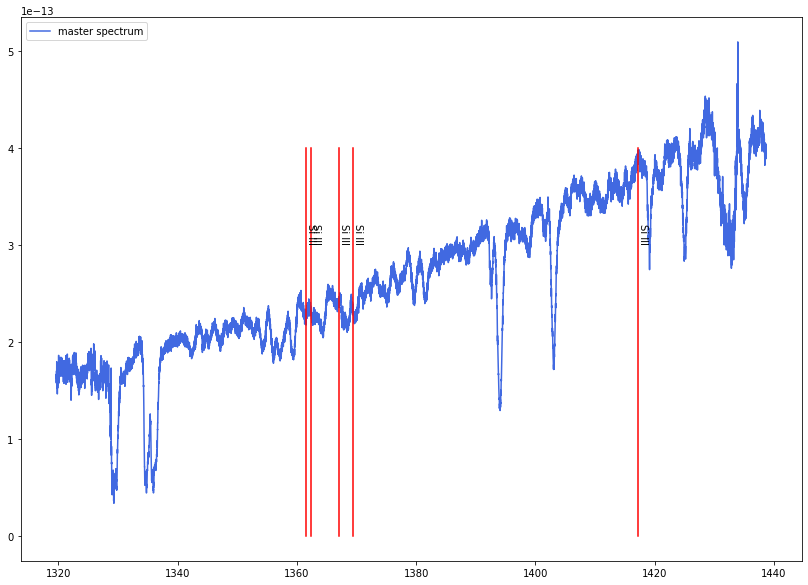

In [8]:
#%matplotlib widget

fig = plt.figure(figsize=(14.0,10.0))
plt.plot(w_shifted, d0_n_w_ave, label="master spectrum", color = "royalblue")
plt.legend(loc='upper left', numpoints=1)

for index, row in df.iterrows():
        if 1320 < row[1] < 1440 and row[2] > 1e9 and 'Si' in row[0]:
            plt.text(row[1],3e-13,row[0],rotation = -90 )
            plt.plot([row[1],row[1]],[0,4e-13],color = "red")

So I am able to plot lines using my expected line list and it all works perfectly, the only problem is the original Mn II lines that I thought I had observed are not present. I believe this is because when making the line list I filtered out all lines without known line strengths (Aki). I think this removed the Mn II lines I had originally observed. (I went back and checked on the line data base and they are not listed with line strengths - this is a problem in my list but I am not sure of where else I can find these lines which might possibly have strengths (so I can have them in the list). 

In any case this is good and it shows that I have learnt how to use pandas and csv files to work with the data. (Objective 2 complete, objective 3 unfinished but unsure how to proceed - Do you know of any more line databases? Aside from AtomicData as you said it also doesnt include Mn? Interestingly I also checked the atomic data file to see if the MnII lines are there, it has other MnII lines but not the ones I mapped. This is making me believe that with such little data on the lines themselves it is unlikey that the lines are significant enought to calculate the column density)

For the rest of week 5 I will be using the atomic data set. Again I went through and reordered the columns in excel (hence the name adjustment)

In [9]:
## 0Ion    1Observed Wavelength      2Strength     3AtomicNumber
import pandas as pd
df = pd.read_csv(home+'/GilesAtomicData.csv',header=None)
print(df)

              0          1            2   3             4   5   6
0           ClI  1000.1150       3430.0  35  7.730000e-07 NaN NaN
1         ArVI*  1000.1700  100000000.0  40  1.000000e-09 NaN NaN
2           ClI  1000.2786   11800000.0  35  8.870000e-04 NaN NaN
3      HDLP4V10  1000.4860  877000000.0   3  9.930000e-03 NaN NaN
4      HDLP8V12  1000.6800  720000000.0   3  8.750000e-03 NaN NaN
...         ...        ...          ...  ..           ...  ..  ..
2350      S I**  1436.9670  240000000.0  32  2.230000e-01 NaN NaN
2351       CoII  1441.8230       3530.0  59  8.550000e-07 NaN NaN
2352        S I  1444.2960    2600000.0  32  8.130000e-04 NaN NaN
2353       CoII  1448.0110  185000000.0  59  4.520000e-02 NaN NaN
2354       NiII  1449.9969   16800000.0  59  3.530000e-03 NaN NaN

[2355 rows x 7 columns]


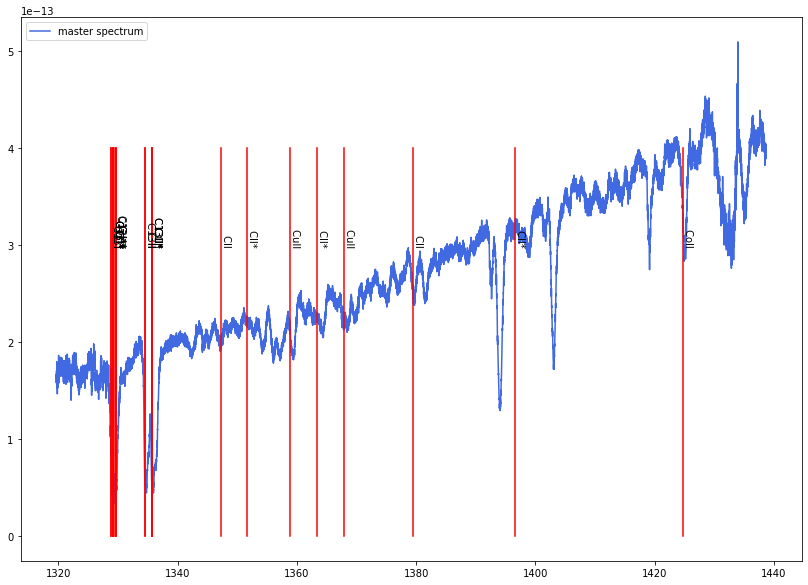

In [10]:
fig = plt.figure(figsize=(14.0,10.0))
plt.plot(w_shifted, d0_n_w_ave, label="master spectrum", color = "royalblue")
plt.legend(loc='upper left', numpoints=1)

for index, row in df.iterrows():
        if 1320 < row[1] < 1440 and row[2] > 1e7 and 'C' in row[0]:
            plt.text(row[1],3e-13,row[0],rotation = -90 )
            plt.plot([row[1],row[1]],[0,4e-13],color = "red")

In [24]:
def lines_predict(List_Name,Ion,lowerw,upperw,line_strength,matplotlib_widget):
    
    #Not sure if this If statement works as I think once the widget is loaded it loads for all following figures.
    if matplotlib_widget == "y" or "yes" or "True":
        %matplotlib widget

    #Loading the selected list - only works for my directory as I have the lists just saved in the "Home" file set at start
    import pandas as pd
    df = pd.read_csv(home+'/'+List_Name+'.csv',header=None)

    #Chnaging the row data types to float so that the for loop's if < row[1] < section works correctly
    df[1] = df[1].astype('float')
    df[2] = df[2].astype('float')
    
    #Plotting the master spectrum - it might be worth also having a condensed version of the w_shifted and weigted average 
    # code so that you can literally use this anywhere and it will work (I thouht it would just make this function huge)
    #This would also be useful because if I had my set_W function in here too, it would fix the problem of when I give a 
    #upper and lower w here that just means it searches for lines in that range but still plots whole spectrum.
    fig = plt.figure(figsize=(10.0,7.0))
    plt.plot(w_shifted, d0_n_w_ave, label="master spectrum", color = "royalblue")
    plt.legend(loc='upper left', numpoints=1)
    
    #Automated title, could be useful for quick graphs which might need to be shown somewhere
    #And useful for just reminding me what I searched for
    if Ion == '': #If Ion is empty it will search for all 
        plt.title("Searching for all Ions in " + List_Name)
    else:  #Anything else will just write what you searched for 
        plt.title("Searching for " + Ion + " in " + List_Name)
    
    
    #The same for loop as before but instead of using hard coded numbers it uses all the inputs of the function only
    for index, row in df.iterrows():
        if lowerw < row[1] < upperw and row[2] > line_strength and Ion in row[0]:
            plt.text(row[1],3e-13,row[0],rotation = -90 )
            plt.plot([row[1],row[1]],[0,4e-13],color = "red")
            
        
        
    

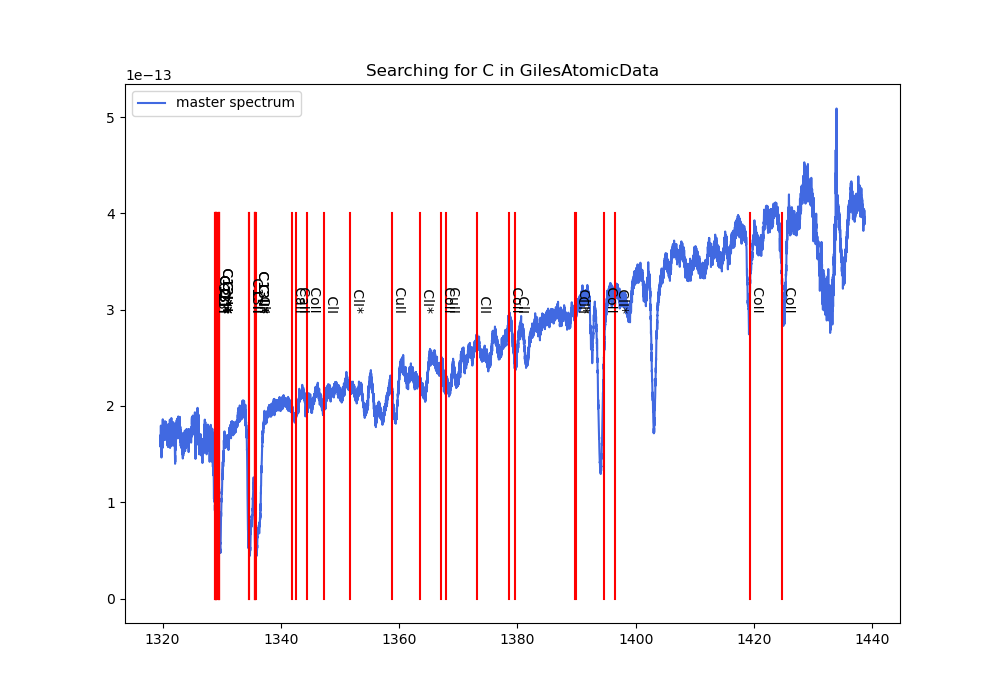

In [25]:
#Testing with AtomicData line list
lines_predict("GilesAtomicData","C",1320,1430,1e+5,"no")

I am seriously intruiged by the cobolt CoII lines on the far right, they are close to perfect matches on this scale but once zoomed in they arent 100% in line. Still I think I will try plotting the column denisty for at least one of these lines. 

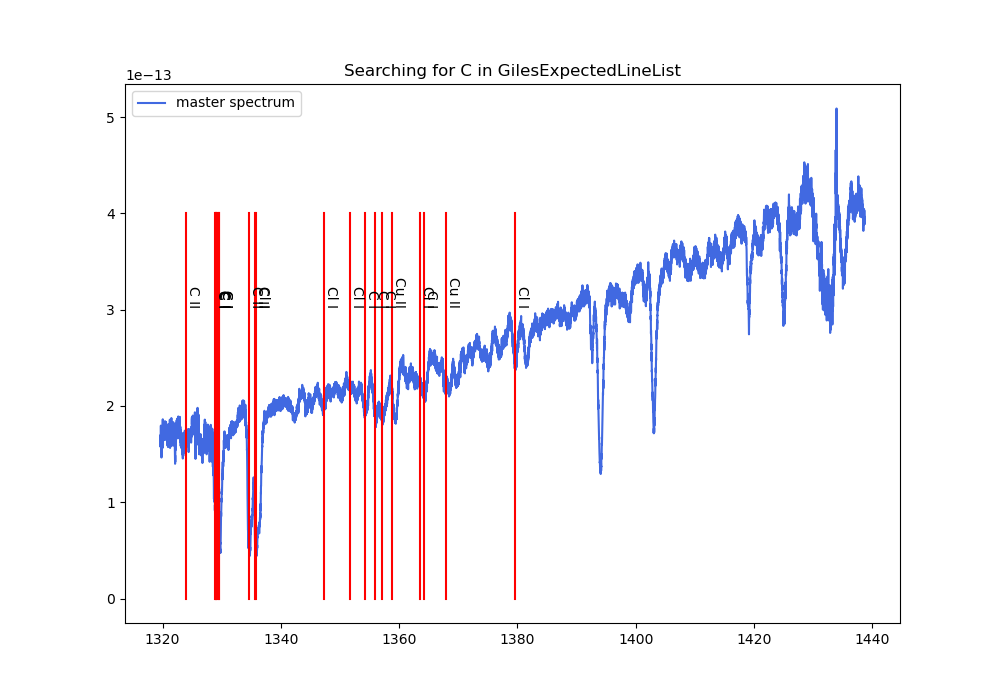

In [40]:
#Testing with my predicted line list - interesting to note similariteis/differences (No cobolt obviosuly, only Carbon and Copper, 
# there are no hyperfine split lines * but they do appear to be in the exact same places on each line -encouraging) 
lines_predict("GilesExpectedLineList","C",1320,1430,1e+7,"yes")

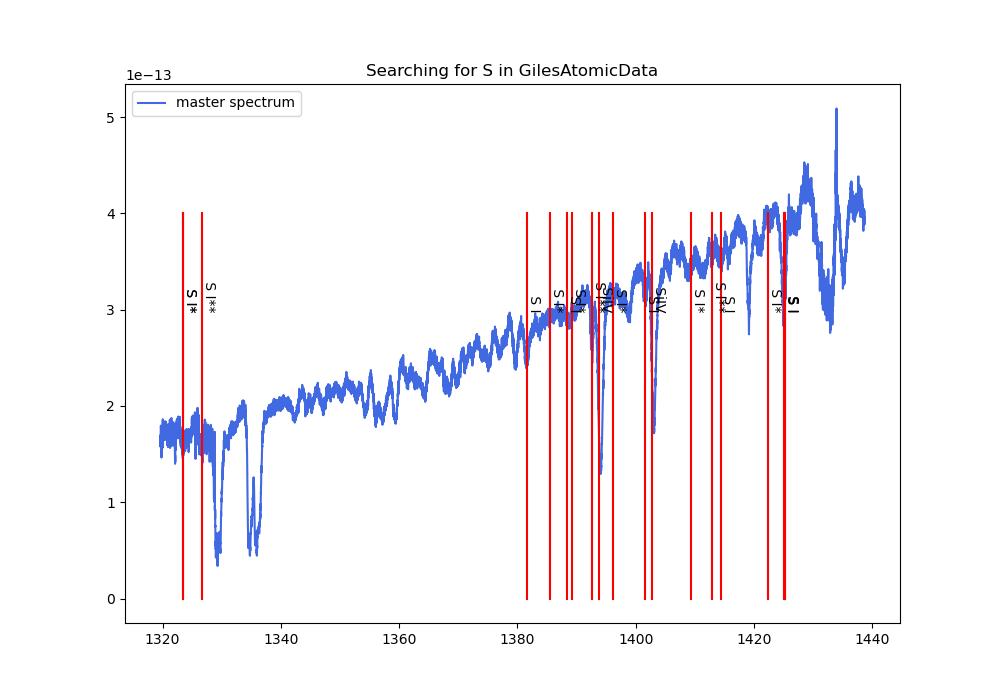

In [31]:
#This is just the graph I was using to test all the variables and look at loads of different elements
# And used this to identify the lines I am interested in finding 
lines_predict("GilesAtomicData","S",1320,1430,1e+5,"yes")

So there I have compeleted my objectives 1,2,3,5. I really like the function here, I think it is actually very usable and if I fix those little notes I had on it it will be even better. I would also like to write a sister function for this code where I could then do "lines_search" and have it print out the lines in that range - would make it easier to find the exact wavelength of the line you are calculating the column density of.*


When I have been playing with all the elements in these
I go on to calculate the column densities in week 5.2 notebook. 

*I had this idea when looking at the cobolt lines in the first example and wanted to find the exact lines - I actually managed to code this very very quickly just by copying most the code from the lines_predict function and swapping what the loop does at the end. As another improvement for the code I could have a true/false statement in the lines_predict variables to ask if I want the line wavelengths printed out too - I would probably also add a number to the end of each label so that you could look at the lne on the graph see it is number 6 and then quickly find number 6 on the wavelength list. 
I have started to realise now I understand how to do all this coding I basically am just writing code and thinking all the time of ways I can add to the code and make it more usable / functional. (It is a good feeling).

In [37]:
#The quick version of the lines_search function - can be improved/directly implemented into the lines_predict code.

def lines_search(List_Name,Ion,lowerw,upperw,line_strength):
    
    #Loading the selected list - only works for my directory as I have the lists just saved in the "Home" file set at start
    import pandas as pd
    df = pd.read_csv(home+'/'+List_Name+'.csv',header=None)

    #Chnaging the row data types to float so that the for loop's if < row[1] < section works correctly
    df[1] = df[1].astype('float')
    df[2] = df[2].astype('float')
    
    
    #Again the same loop but this time instead of adding lines to a spectrum it just prints out a description of the lines
    # which fit the search 
    for index, row in df.iterrows():
        if lowerw < row[1] < upperw and row[2] > line_strength and Ion in row[0]:
            print(row[0],row[1])
            

In [38]:
lines_search("GilesAtomicData","C",1320,1430,1e+5)

 C13I 1328.825
 C I 1328.8333
 C13I* 1329.079
 C I* 1329.085
 C13I* 1329.094
 C I* 1329.1003
 C13I* 1329.115
 C I* 1329.1233
 C13I** 1329.5699
 C I** 1329.5775
 C13I** 1329.592
 C I** 1329.6003
 C II 1334.532
 C13II 1334.561
 C13II* 1335.649
 C II* 1335.663
 C13II* 1335.692
 C II* 1335.708
 ClI 1335.7258
 CaII 1341.89
 CaII 1342.554
 CoII 1344.5
 ClI 1347.2396
 ClI* 1351.6561
 CuII 1358.7729
 ClI* 1363.4474
 CoII 1367.106
 CuII 1367.9509
 ClI 1373.1165
 CoII 1378.6379
 ClI 1379.528
 ClI 1389.6925
 ClI* 1389.9567
 CoII 1394.6379
 ClI* 1396.5269
 CoII 1419.287
 CoII 1424.7791


In [39]:
lines_search("GilesAtomicData","S",1420,1430,1e+5)

 S I* 1422.3387
 S I 1425.0299
 S I 1425.1877
 S I 1425.2189
